<a href="https://colab.research.google.com/github/nir-fogel/Eurosat-dataset-ML-classification/blob/main/Eurosat_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from keras.utils import to_categorical
from keras import callbacks
from keras import activations
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**TO DO 3**

importing the Eurosat dataset

In [2]:
ds_rgb, info = tfds.load('eurosat/rgb',shuffle_files=True, as_supervised = True, with_info = True) #as_supervised = True,

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteN306YI/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


Printing the info of the Eurosat dataset

In [3]:
print(info)
print(type(ds_rgb["train"]))
#print(info.citation)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir=PosixGPath('/tmp/tmpl7he0w_htfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('ima

Getting the amount of classes and creating the list of labels

In [4]:
print(info.features['label'].num_classes)

10


In [5]:
labels = info.features["label"].names
print(labels)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Printing 18 example images

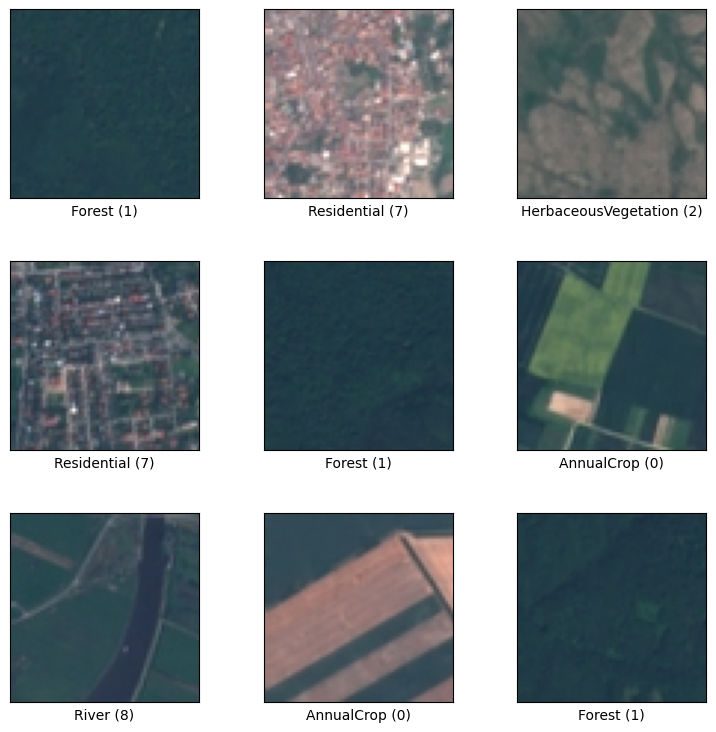

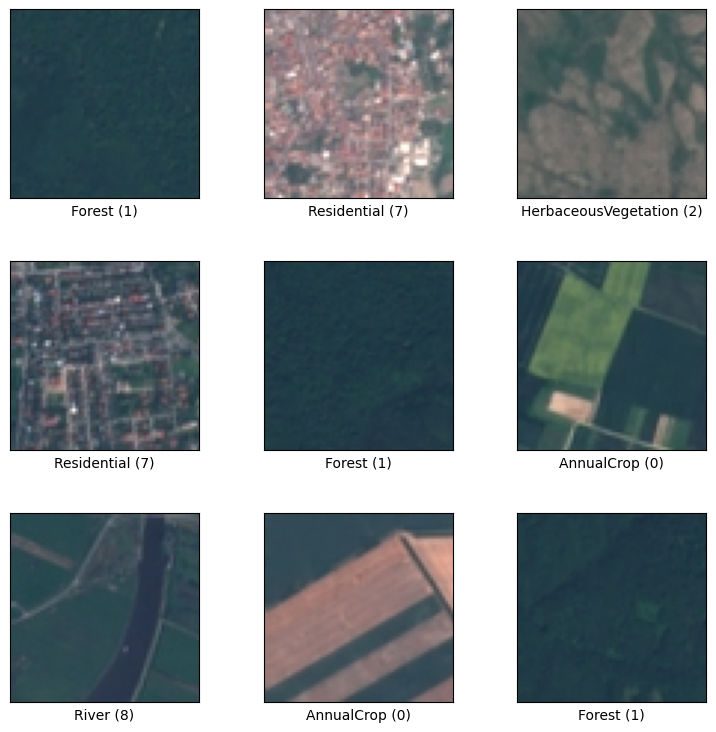

In [6]:
ds, info = tfds.load('eurosat', split='train', with_info=True)

tfds.show_examples(ds, info)

Seperating the dataset into x_train and y_train

In [7]:
x_train = []
y_train = []
for element in ds_rgb['train'].as_numpy_iterator():
  x_train.append(element[0])
  y_train.append(element[1])

In [8]:
print(len(x_train))
print(len(y_train))

27000
27000


In [9]:
counts = []
for i in range(0,10):
  count = 0
  for j in range(len(y_train)):
    if (y_train[j] == i):
      count +=1
  counts.append(count)
print(counts)

[3000, 3000, 3000, 2500, 2500, 2000, 2500, 3000, 2500, 3000]


Creating a new dataset with equal amouts of examples per class type

In [10]:
minimum = np.min(counts)
minimum

2000

In [11]:
new_data_x = []
new_data_y = []
count = [0,0,0,0,0,0,0,0,0,0]
for i in range(len(y_train)):
  if (count[y_train[i]] < minimum):
    new_data_x.append(x_train[i])
    new_data_y.append(y_train[i])
    count[y_train[i]] += 1
print(len(new_data_x))
print(len(new_data_y))
print(new_data_x[0].shape)
print(count)
print(counts)

20000
20000
(64, 64, 3)
[2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
[3000, 3000, 3000, 2500, 2500, 2000, 2500, 3000, 2500, 3000]


In [12]:
new_data_x_np = np.array(new_data_x)
new_data_x_tf = tf.convert_to_tensor(new_data_x_np, dtype=np.float32)

In [13]:
new_data_y_np = np.array(new_data_y)
new_data_y_tf = tf.convert_to_tensor(new_data_y_np, dtype=np.float32)

In [14]:
balanced_eurosat = tf.data.Dataset.from_tensor_slices((new_data_x_tf, new_data_y_tf))
balanced_eurosat

<_TensorSliceDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

Normalizing all values of the rgb

In [15]:
def normalize_img(new_data_x,new_data_y):
    return tf.cast(new_data_x, tf.float32) / 255., new_data_y

In [16]:
#balanced_eurosat = balanced_eurosat.map(normalize_img,
                      #num_parallel_calls=tf.data.AUTOTUNE)

Creating a training pipeline with an 80/20 validation split

In [17]:
balanced_eurosat = balanced_eurosat.shuffle(buffer_size=20_000)

In [18]:
val_eurosat = balanced_eurosat.take(4000)
train_eurosat = balanced_eurosat.skip(4000)
val_eurosat = val_eurosat.map(normalize_img,
                      num_parallel_calls=tf.data.AUTOTUNE)
train_eurosat = train_eurosat.map(normalize_img,
                      num_parallel_calls=tf.data.AUTOTUNE)

**TO DO 4**

importing and using the VGG16 network

In [19]:
vgg =tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(64,64,3),
    classes = 10
)

58889256/58889256 [==============================] - 4s 0us/step


In [20]:
for layer in vgg.layers:
  layer.trainable = False

In [21]:
model = vgg.output
model = Flatten()(model)
model = Dense(units = 1000, activation ='relu')(model)
model = Dense(units = 256, activation = 'relu')(model)
model = Dense(units = 12, activation = 'relu')(model)
model = Dense(units = 10, activation = 'softmax')(model)

model = Model(outputs = model, inputs = vgg.inputs)

In [22]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [23]:
#keras.utils.plot_model(model, "my_first_model.png")

In [24]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
early_stopping_callback = callbacks.EarlyStopping(
    monitor = "val_accuracy",
    min_delta = 0.0001,
    patience= 10,
    verbose = 0,
    mode = "auto",
    restore_best_weights = True,
)

backupandrestore_callback = callbacks.BackupAndRestore(
    "/content/drive/MyDrive/Eurosat_mini_proj/Backup", save_freq = "epoch"
)

model_checkpoint = callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/callback_practice/Eurosat_mini_proj/Checkpoint",
    monitor = "val_accuracy",
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq = "epoch",
)

callback_list = [model_checkpoint, backupandrestore_callback]

In [26]:
val_eurosat= val_eurosat.batch(128)
train_eurosat= train_eurosat.batch(128)

In [27]:
history = model.fit(train_eurosat, validation_data= val_eurosat, epochs=10, verbose=2)# , callbacks = callback_list

Epoch 1/10
125/125 - 18s - loss: 1.0361 - accuracy: 0.6421 - val_loss: 0.7338 - val_accuracy: 0.7735 - 18s/epoch - 141ms/step
Epoch 2/10
125/125 - 7s - loss: 0.6099 - accuracy: 0.7981 - val_loss: 0.5155 - val_accuracy: 0.8328 - 7s/epoch - 52ms/step
Epoch 3/10
125/125 - 6s - loss: 0.4962 - accuracy: 0.8359 - val_loss: 0.4122 - val_accuracy: 0.8633 - 6s/epoch - 52ms/step
Epoch 4/10
125/125 - 8s - loss: 0.4286 - accuracy: 0.8531 - val_loss: 0.3670 - val_accuracy: 0.8830 - 8s/epoch - 62ms/step
Epoch 5/10
125/125 - 6s - loss: 0.3736 - accuracy: 0.8756 - val_loss: 0.3278 - val_accuracy: 0.8910 - 6s/epoch - 51ms/step
Epoch 6/10
125/125 - 6s - loss: 0.3427 - accuracy: 0.8836 - val_loss: 0.3141 - val_accuracy: 0.8895 - 6s/epoch - 49ms/step
Epoch 7/10
125/125 - 7s - loss: 0.3195 - accuracy: 0.8923 - val_loss: 0.2832 - val_accuracy: 0.9068 - 7s/epoch - 52ms/step
Epoch 8/10
125/125 - 6s - loss: 0.2896 - accuracy: 0.9018 - val_loss: 0.2470 - val_accuracy: 0.9183 - 6s/epoch - 49ms/step
Epoch 9/10
12

Checking the accuracy of the model

In [28]:
a = history.history
type(a)

dict

In [29]:
type(history.history['loss'])

list

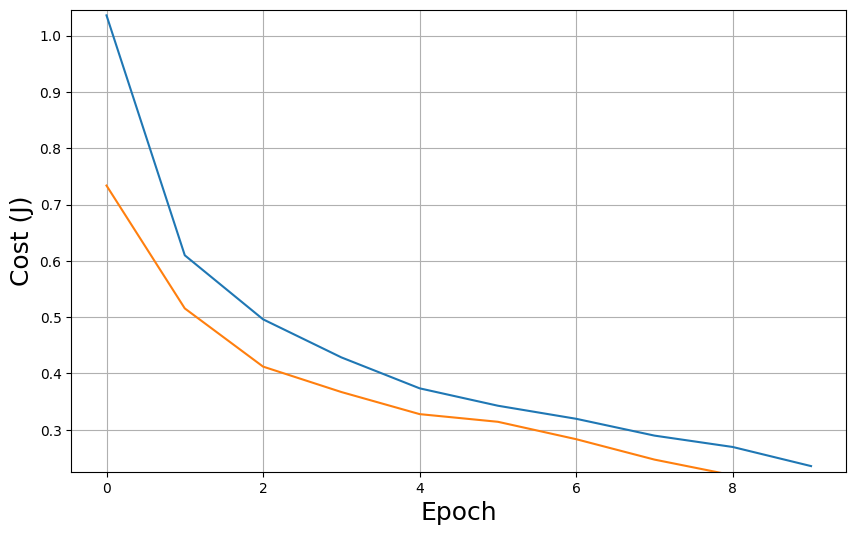

In [30]:
plt.figure(figsize = (10,6))
plt.ylim(min(history.history['loss']) - 0.01 , max(history.history['loss']) + 0.01)
plt.xlabel('Epoch' , fontsize = 18)
plt.ylabel('Cost (J)' , fontsize = 18)
plt.grid(True)
plt.plot(history.history['loss'], label='Cost')
plt.plot(history.history['val_loss'], label='val_Cost')

In [31]:
#type(ds_rgb)
#print(ds_rgb.keys())
#type(ds_rgb['train'])

In [32]:
predictions = model.predict(x= val_eurosat, verbose = 0)
rounded_predictions = np.argmax(predictions,axis=1)

In [33]:
def cm_to_metrics_df(cm):
  acc = np.trace(cm) / np.sum(cm)
  accuracy = []
  for i in range(cm.shape[0]):
    accuracy.append(acc)
  precision = []
  for i in range(cm.shape[0]):
    precision.append(cm[i , i] / cm[: , i].sum())
  recall = []
  for i in range(cm.shape[0]):
    recall.append(cm[i , i] / cm[i , :].sum())
  f1 = []
  for i in range(cm.shape[0]):
    f1.append(2 * precision[i] * recall[i] / (precision[i] + recall[i]))
  columns = []
  for i in range(cm.shape[0]):
    columns.append(str(i))
  summary_df = pd.DataFrame(index = ['Accuracy' , 'Precision' , 'Recall' , 'F1-score'])
  for i in range(cm.shape[0]):
    t = str(i)
    summary_df[t] = [accuracy[i] , precision[i] , recall[i] , f1[i]]
  return summary_df

def create_cm(m: keras.Model, ds, info):
  ds_unbatch = [i for i in ds.unbatch()]
  x = np.array([i for i, j in ds_unbatch])
  y = np.array([j for i, j in ds_unbatch])

  predicts = m.predict(x)
  y_true = y
  y_pred = np.argmax(predicts, axis=-1)
  size = info.features['label'].num_classes

  # calculate the confusion matrix
  cm = confusion_matrix(y_true, y_pred, labels=range(size))

  # create a heatmap of the confusion matrix
  sns.heatmap(cm, annot=True, cmap="OrRd", fmt="d", xticklabels=labels, yticklabels=labels)

  # set the axis labels and title
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")

  # show the plot
  plt.show()

  return cm

125/125 [==============================] - 2s 14ms/step


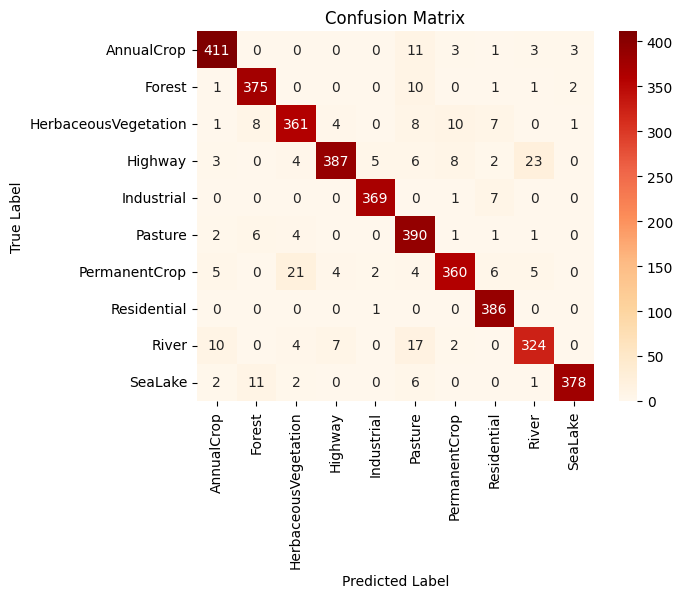

,0,1,2,3,4,5,6,7,8,9
Accuracy,0.935250,0.935250,0.935250,0.935250,0.93525,0.935250,0.935250,0.935250,0.935250,0.935250
Precision,0.944828,0.937500,0.911616,0.962687,0.97878,0.862832,0.935065,0.939173,0.905028,0.984375
Recall,0.951389,0.961538,0.902500,0.883562,0.97878,0.962963,0.884521,0.997416,0.890110,0.945000
F1-score,0.948097,0.949367,0.907035,0.921429,0.97878,0.910152,0.909091,0.967419,0.897507,0.964286


In [34]:
cm_to_metrics_df(create_cm(model, val_eurosat, info))

In [35]:
model.save('/content/drive/MyDrive/Eurosat_mini_proj/VGG16_full_freeze')

Trying to unfreeze some of the layers

In [36]:
vgg2 =tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(64,64,3),
    classes = 10
)

In [37]:
for layer in vgg2.layers[:-3]:
  layer.trainable = False

In [38]:
model2 = vgg2.output
model2 = Flatten()(model2)
model2 = Dense(units = 256, activation ='relu')(model2)
model2 = Dense(units = 256, activation ='relu')(model2)
model2 = Dense(units = 256, activation ='relu')(model2)
model2 = Dense(units = 10, activation = 'softmax')(model2)

model2 = Model(outputs = model2, inputs = vgg2.inputs)

In [39]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [40]:
model2.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
history2 = model2.fit(train_eurosat, validation_data= val_eurosat, epochs=20, verbose=2)# , callbacks = callback_list

Epoch 1/20
125/125 - 12s - loss: 1.9585 - accuracy: 0.4371 - val_loss: 0.7984 - val_accuracy: 0.6988 - 12s/epoch - 93ms/step
Epoch 2/20
125/125 - 7s - loss: 0.7389 - accuracy: 0.7255 - val_loss: 0.6382 - val_accuracy: 0.7785 - 7s/epoch - 56ms/step
Epoch 3/20
125/125 - 7s - loss: 0.5870 - accuracy: 0.8025 - val_loss: 0.5565 - val_accuracy: 0.8115 - 7s/epoch - 59ms/step
Epoch 4/20
125/125 - 7s - loss: 0.4481 - accuracy: 0.8509 - val_loss: 0.3422 - val_accuracy: 0.8907 - 7s/epoch - 60ms/step
Epoch 5/20
125/125 - 8s - loss: 0.3538 - accuracy: 0.8814 - val_loss: 0.3301 - val_accuracy: 0.8890 - 8s/epoch - 63ms/step
Epoch 6/20
125/125 - 7s - loss: 0.3209 - accuracy: 0.8938 - val_loss: 0.2686 - val_accuracy: 0.9125 - 7s/epoch - 58ms/step
Epoch 7/20
125/125 - 7s - loss: 0.3000 - accuracy: 0.9032 - val_loss: 0.2612 - val_accuracy: 0.9112 - 7s/epoch - 60ms/step
Epoch 8/20
125/125 - 8s - loss: 0.2933 - accuracy: 0.9046 - val_loss: 0.2373 - val_accuracy: 0.9202 - 8s/epoch - 68ms/step
Epoch 9/20
125

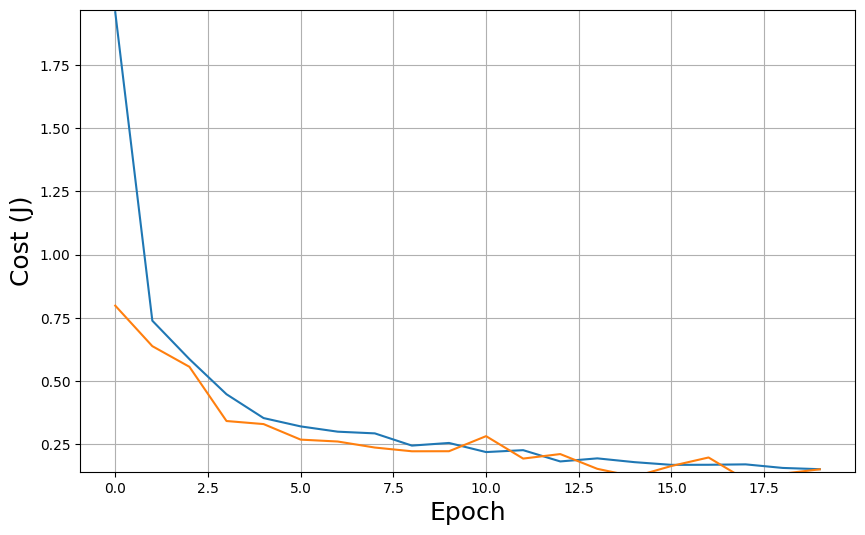

In [42]:
plt.figure(figsize = (10,6))
plt.ylim(min(history2.history['loss']) - 0.01 , max(history2.history['loss']) + 0.01)
plt.xlabel('Epoch' , fontsize = 18)
plt.ylabel('Cost (J)' , fontsize = 18)
plt.grid(True)
plt.plot(history2.history['loss'], label='Cost')
plt.plot(history2.history['val_loss'], label='val_Cost')

125/125 [==============================] - 2s 14ms/step


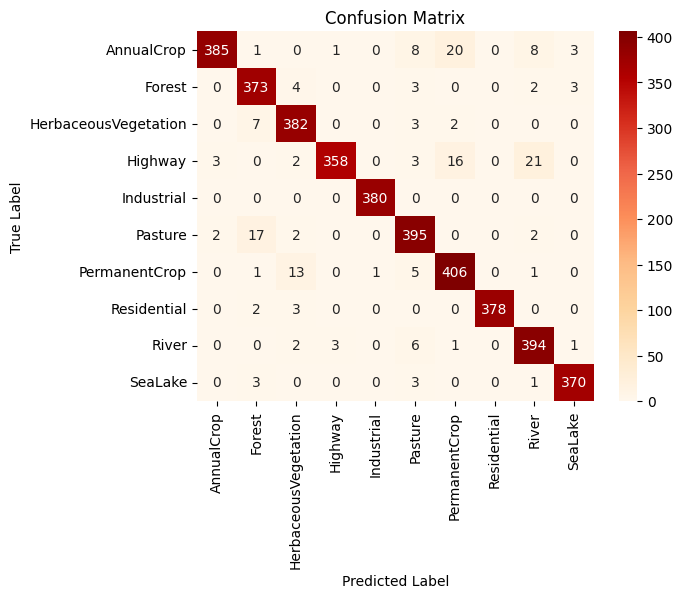

,0,1,2,3,4,5,6,7,8,9
Accuracy,0.955250,0.955250,0.955250,0.955250,0.955250,0.955250,0.955250,0.955250,0.955250,0.955250
Precision,0.987179,0.923267,0.936275,0.988950,0.997375,0.927230,0.912360,1.000000,0.918415,0.981432
Recall,0.903756,0.968831,0.969543,0.888337,1.000000,0.944976,0.950820,0.986945,0.968059,0.981432
F1-score,0.943627,0.945501,0.952618,0.935948,0.998686,0.936019,0.931193,0.993430,0.942584,0.981432


In [43]:
cm_to_metrics_df(create_cm(model2, val_eurosat, info))

In [44]:
#model2.save('/content/drive/MyDrive/Eurosat_mini_proj/VGG16_freeze_-3')

In [45]:
def prepare_training_data(image, label):

  if tf.random.uniform(()) > 0.5:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta = 0.3)
    image = tf.image.random_saturation(image, lower=0.75, upper=1.5)
    image = tf.image.random_contrast(image, lower=0.75, upper=1.5)

  return image, label

In [46]:
train_ds = train_eurosat.repeat(2)
augmented_train_ds = train_ds.map(prepare_training_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [47]:
vgg3 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64,3),
    classes=10,
)

In [48]:
for i in vgg3.layers[:-5]:
  i.trainable = False

In [49]:
model3 = vgg3.output
model3 = Flatten()(model3)
model3 = Dense(units = 256, activation = 'relu', kernel_initializer="glorot_uniform")(model3)
model3 = Dense(units = 256, activation = 'relu', kernel_initializer="glorot_uniform")(model3)
model3 = Dense(units = 256, activation = 'relu')(model3)
model3 = Dense(units = 10, activation = 'softmax')(model3)

model3 = Model(outputs = model3, inputs = vgg3.input)

In [50]:
model3.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [51]:
history3 = model3.fit(augmented_train_ds, validation_data= val_eurosat, epochs=20, verbose=2)# , callbacks = callback_list

Epoch 1/20
250/250 - 18s - loss: 0.7347 - accuracy: 0.7453 - val_loss: 0.4045 - val_accuracy: 0.8725 - 18s/epoch - 74ms/step
Epoch 2/20
250/250 - 15s - loss: 0.3964 - accuracy: 0.8700 - val_loss: 0.3045 - val_accuracy: 0.9153 - 15s/epoch - 59ms/step
Epoch 3/20
250/250 - 16s - loss: 0.3304 - accuracy: 0.8933 - val_loss: 0.2056 - val_accuracy: 0.9380 - 16s/epoch - 65ms/step
Epoch 4/20
250/250 - 16s - loss: 0.2919 - accuracy: 0.9047 - val_loss: 0.2425 - val_accuracy: 0.9250 - 16s/epoch - 66ms/step
Epoch 5/20
250/250 - 15s - loss: 0.2770 - accuracy: 0.9100 - val_loss: 0.2086 - val_accuracy: 0.9325 - 15s/epoch - 61ms/step
Epoch 6/20
250/250 - 15s - loss: 0.2568 - accuracy: 0.9153 - val_loss: 0.2057 - val_accuracy: 0.9342 - 15s/epoch - 59ms/step
Epoch 7/20
250/250 - 15s - loss: 0.2421 - accuracy: 0.9189 - val_loss: 0.1471 - val_accuracy: 0.9560 - 15s/epoch - 60ms/step
Epoch 8/20
250/250 - 15s - loss: 0.2192 - accuracy: 0.9310 - val_loss: 0.1229 - val_accuracy: 0.9607 - 15s/epoch - 59ms/step


In [52]:
#model.save('/content/drive/MyDrive/Eurosat_mini_proj/VGG16_augment')

In [53]:
a = history3.history

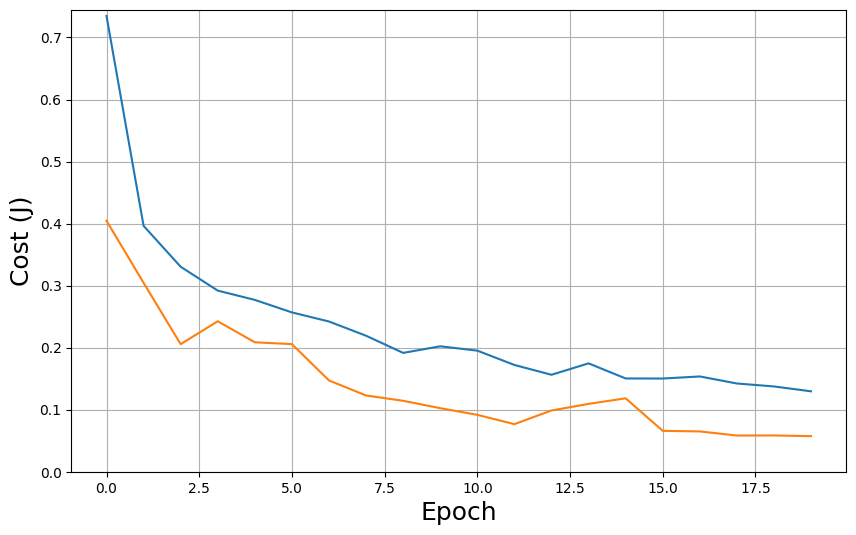

In [54]:
plt.figure(figsize = (10,6))
plt.ylim(0 , max(a['loss']) + 0.01)
plt.xlabel('Epoch' , fontsize = 18)
plt.ylabel('Cost (J)' , fontsize = 18)
plt.grid(True)
plt.plot(a['loss'], label='Cost')
plt.plot(a['val_loss'], label='val_Cost')

125/125 [==============================] - 2s 14ms/step


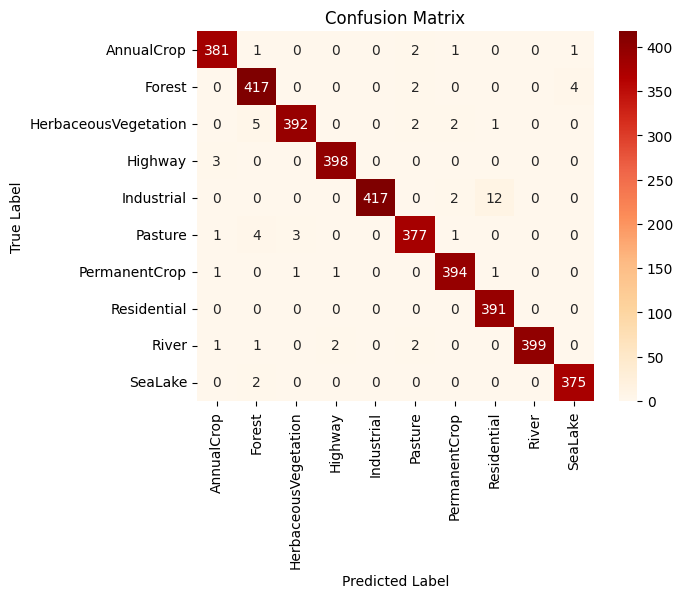

,0,1,2,3,4,5,6,7,8,9
Accuracy,0.985250,0.985250,0.985250,0.985250,0.985250,0.985250,0.985250,0.985250,0.985250,0.985250
Precision,0.984496,0.969767,0.989899,0.992519,1.000000,0.979221,0.985000,0.965432,1.000000,0.986842
Recall,0.987047,0.985816,0.975124,0.992519,0.967517,0.976684,0.989950,1.000000,0.985185,0.994695
F1-score,0.985770,0.977726,0.982456,0.992519,0.983491,0.977951,0.987469,0.982412,0.992537,0.990753


In [55]:
cm_to_metrics_df(create_cm(model3, val_eurosat, info))

In [56]:
ResNet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64,3),
    classes=10,
)

94765736/94765736 [==============================] - 5s 0us/step


In [57]:
for i in ResNet.layers:
  i.trainable = False

In [58]:
model4 = ResNet.output
model4 = Flatten()(model4)
model4 = Dense(units = 256, activation = 'relu')(model4)
model4 = Dense(units = 256, activation = 'relu')(model4)
model4 = Dense(units = 256, activation = 'relu')(model4)
model4 = Dense(units = 10, activation = 'softmax')(model4)

model4 = Model(outputs = model4, inputs = ResNet.input)

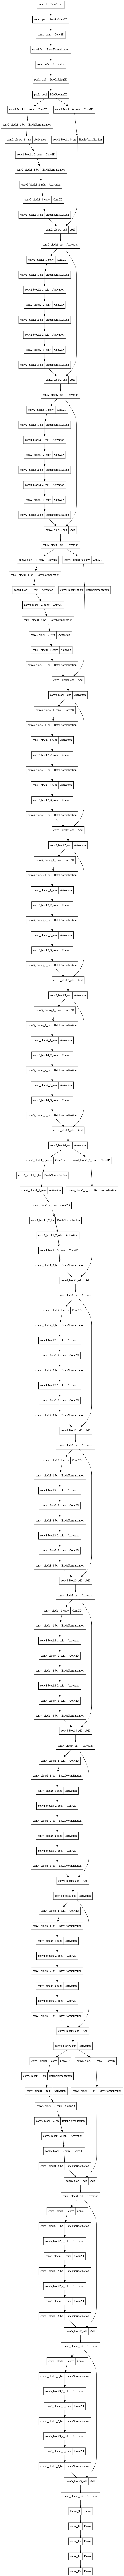

In [59]:
keras.utils.plot_model(model4, "my_first_model.png")

In [60]:
def prepare_validation_data(new_data_x, new_data_y):
    return preprocess_input(new_data_x), new_data_y

In [61]:
val_Res = balanced_eurosat.take(4000)
train_Res = balanced_eurosat.skip(4000)
val_Res = val_Res.map(prepare_validation_data,
                      num_parallel_calls=tf.data.AUTOTUNE)
train_Res = train_Res.map(prepare_validation_data,
                      num_parallel_calls=tf.data.AUTOTUNE)

In [62]:
val_Res = val_Res.batch(128)
train_Res = train_Res.batch(128)

In [63]:
model4.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [64]:
history4 = model4.fit(train_Res, validation_data= val_Res, epochs=20, verbose=2)#, callbacks = callback_list

Epoch 1/20
125/125 - 16s - loss: 0.4561 - accuracy: 0.8573 - val_loss: 0.1672 - val_accuracy: 0.9425 - 16s/epoch - 124ms/step
Epoch 2/20
125/125 - 7s - loss: 0.1927 - accuracy: 0.9362 - val_loss: 0.0939 - val_accuracy: 0.9700 - 7s/epoch - 53ms/step
Epoch 3/20
125/125 - 6s - loss: 0.1217 - accuracy: 0.9588 - val_loss: 0.0754 - val_accuracy: 0.9770 - 6s/epoch - 46ms/step
Epoch 4/20
125/125 - 8s - loss: 0.0874 - accuracy: 0.9702 - val_loss: 0.0775 - val_accuracy: 0.9725 - 8s/epoch - 65ms/step
Epoch 5/20
125/125 - 8s - loss: 0.0701 - accuracy: 0.9763 - val_loss: 0.0553 - val_accuracy: 0.9815 - 8s/epoch - 62ms/step
Epoch 6/20
125/125 - 7s - loss: 0.0470 - accuracy: 0.9831 - val_loss: 0.0405 - val_accuracy: 0.9862 - 7s/epoch - 55ms/step
Epoch 7/20
125/125 - 6s - loss: 0.0504 - accuracy: 0.9828 - val_loss: 0.0303 - val_accuracy: 0.9910 - 6s/epoch - 46ms/step
Epoch 8/20
125/125 - 8s - loss: 0.0470 - accuracy: 0.9849 - val_loss: 0.0333 - val_accuracy: 0.9890 - 8s/epoch - 63ms/step
Epoch 9/20
12

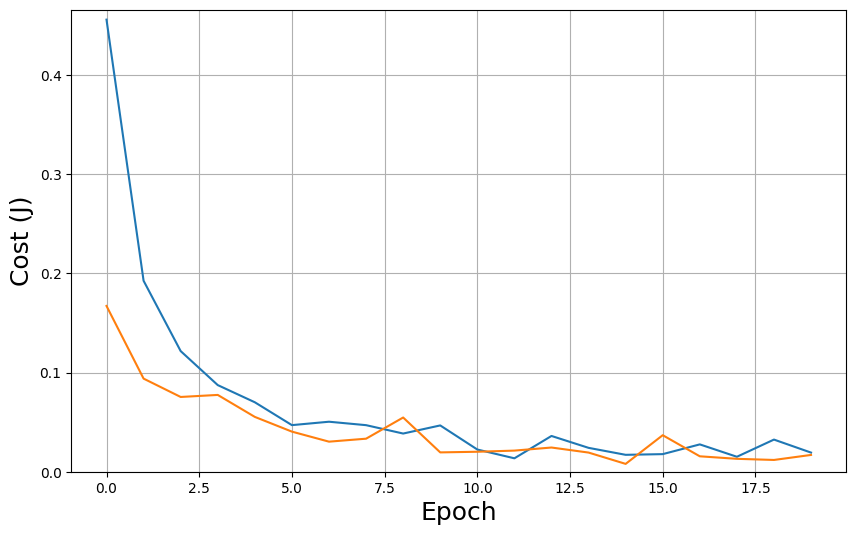

In [65]:
plt.figure(figsize = (10,6))
plt.ylim(0, max(history4.history['loss']) + 0.01)
plt.xlabel('Epoch' , fontsize = 18)
plt.ylabel('Cost (J)' , fontsize = 18)
plt.grid(True)
plt.plot(history4.history['loss'], label='Cost')
plt.plot(history4.history['val_loss'], label='val_Cost')

125/125 [==============================] - 3s 13ms/step


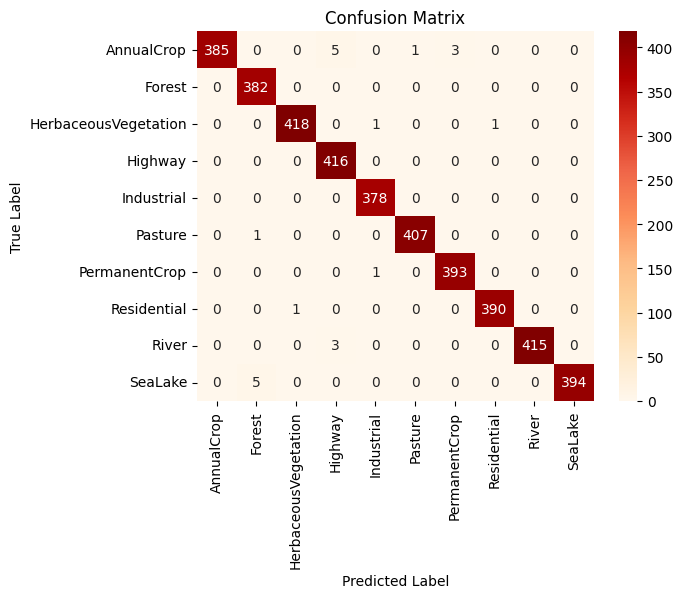

,0,1,2,3,4,5,6,7,8,9
Accuracy,0.994500,0.994500,0.994500,0.994500,0.994500,0.994500,0.994500,0.994500,0.994500,0.994500
Precision,1.000000,0.984536,0.997613,0.981132,0.994737,0.997549,0.992424,0.997442,1.000000,1.000000
Recall,0.977157,1.000000,0.995238,1.000000,1.000000,0.997549,0.997462,0.997442,0.992823,0.987469
F1-score,0.988447,0.992208,0.996424,0.990476,0.997361,0.997549,0.994937,0.997442,0.996399,0.993695


In [66]:
cm_to_metrics_df(create_cm(model4, val_Res, info))

In [67]:
#model4.save('/content/drive/MyDrive/Eurosat_mini_proj/ResNet')

In [68]:
Res2 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64,3),
    classes=10,
)

In [69]:
for i in Res2.layers:
  i.trainable = False

In [70]:
model5 = Res2.output
model5 = Flatten()(model5)
model5 = Dense(units = 256, activation = 'relu')(model5)
model5 = Dense(units = 256, activation = 'relu')(model5)
model5 = Dense(units = 256, activation = 'relu')(model5)
model5 = Dense(units = 10, activation = 'softmax')(model5)

model5 = Model(outputs = model5, inputs = Res2.input)

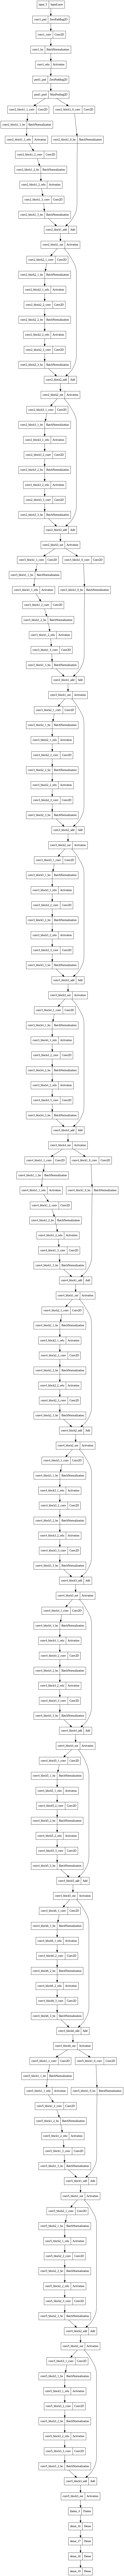

In [71]:
keras.utils.plot_model(model5, "my_second_model.png")

In [72]:

val_Res_eurosat = balanced_eurosat.take(4000)
train_Res_eurosat = balanced_eurosat.skip(4000)
val_Res_eurosat = val_Res_eurosat.map(prepare_validation_data,
                      num_parallel_calls=tf.data.AUTOTUNE)
train_Res_eurosat = train_Res_eurosat.map(prepare_validation_data,
                      num_parallel_calls=tf.data.AUTOTUNE)

In [73]:
train_Res_ds = train_Res_eurosat.repeat(2)
augmented_train_Res_ds = train_Res_ds.map(prepare_training_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [74]:
augmented_train_Res_ds = augmented_train_Res_ds.batch(128)
val_Res_eurosat = val_Res_eurosat.batch(128)

In [75]:
print(train_Res)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [76]:
print(augmented_train_Res_ds)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [77]:
model5.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [78]:
history5 = model5.fit(augmented_train_Res_ds, validation_data= val_Res_eurosat, epochs=20, verbose=2)#, callbacks = callback_list

Epoch 1/20
250/250 - 19s - loss: 0.4158 - accuracy: 0.8647 - val_loss: 0.1953 - val_accuracy: 0.9348 - 19s/epoch - 77ms/step
Epoch 2/20
250/250 - 15s - loss: 0.2371 - accuracy: 0.9192 - val_loss: 0.1213 - val_accuracy: 0.9632 - 15s/epoch - 61ms/step
Epoch 3/20
250/250 - 13s - loss: 0.1893 - accuracy: 0.9344 - val_loss: 0.0885 - val_accuracy: 0.9695 - 13s/epoch - 51ms/step
Epoch 4/20
250/250 - 15s - loss: 0.1644 - accuracy: 0.9447 - val_loss: 0.0769 - val_accuracy: 0.9743 - 15s/epoch - 60ms/step
Epoch 5/20
250/250 - 15s - loss: 0.1471 - accuracy: 0.9503 - val_loss: 0.0547 - val_accuracy: 0.9825 - 15s/epoch - 59ms/step
Epoch 6/20
250/250 - 17s - loss: 0.1253 - accuracy: 0.9571 - val_loss: 0.0398 - val_accuracy: 0.9865 - 17s/epoch - 67ms/step
Epoch 7/20
250/250 - 14s - loss: 0.1185 - accuracy: 0.9602 - val_loss: 0.0470 - val_accuracy: 0.9837 - 14s/epoch - 55ms/step
Epoch 8/20
250/250 - 15s - loss: 0.1104 - accuracy: 0.9630 - val_loss: 0.0397 - val_accuracy: 0.9852 - 15s/epoch - 60ms/step


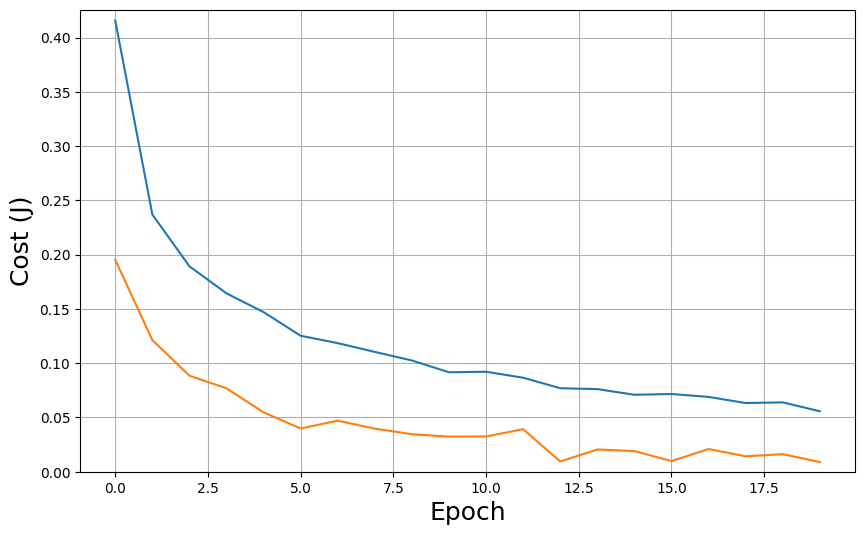

In [79]:
plt.figure(figsize = (10,6))
plt.ylim(0, max(history5.history['loss']) + 0.01)
plt.xlabel('Epoch' , fontsize = 18)
plt.ylabel('Cost (J)' , fontsize = 18)
plt.grid(True)
plt.plot(history5.history['loss'], label='Cost')
plt.plot(history5.history['val_loss'], label='val_Cost')

125/125 [==============================] - 3s 13ms/step


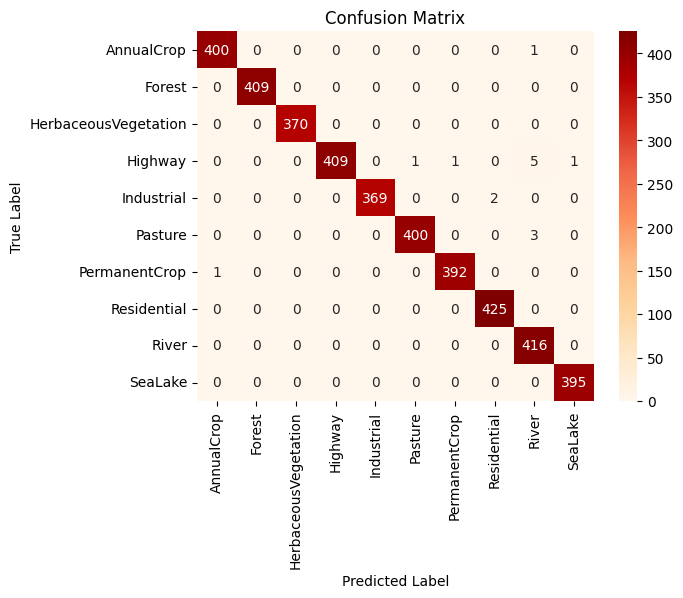

,0,1,2,3,4,5,6,7,8,9
Accuracy,0.996250,0.99625,0.99625,0.996250,0.996250,0.996250,0.996250,0.996250,0.996250,0.996250
Precision,0.997506,1.00000,1.00000,1.000000,1.000000,0.997506,0.997455,0.995316,0.978824,0.997475
Recall,0.997506,1.00000,1.00000,0.980815,0.994609,0.992556,0.997455,1.000000,1.000000,1.000000
F1-score,0.997506,1.00000,1.00000,0.990315,0.997297,0.995025,0.997455,0.997653,0.989298,0.998736


In [80]:
cm_to_metrics_df(create_cm(model5, val_Res_eurosat, info))